In [15]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [13]:
REPO_ID = "inria-soda/tabular-benchmark"
clf_cat = [
    'albert.csv', 
   'compas-two-years.csv', 
   'covertype.csv', 
   'default-of-credit-card-clients.csv',
   'electricity.csv',
   'eye_movements.csv',
   'road-safety.csv'
]

clf_num = [
    'Bioresponse.csv',
    'Diabetes130US.csv',
    'Higgs.csv',
    'MagicTelescope.csv',
    'MiniBooNE.csv',
    'bank-marketing.csv',
    'california.csv',
    'covertype.csv',
    'credit.csv',
    'default-of-credit-card-clients.csv',
    'electricity.csv',
    'eye_movements.csv',
    'heloc.csv',
    'house_16H.csv',
    'jannis.csv',
    'pol.csv'
]

reg_cat = [
    'Airlines_DepDelay_1M.csv',
    'Allstate_Claims_Severity.csv',
    'Bike_Sharing_Demand.csv',
    'Brazilian houses.csv',
    'Mercedes_Benz_Greener_Manufacturing.csv',
    'SGEMM_GPU_kernel_performance.csv',
    'abalone.csv',
    'analcatdata_supreme.csv',
    'delays_zurich_transport.csv',
    'diamonds.csv',
    'house_sales.csv',
    'medical_charges.csv',
    'nyc-taxi-green-dec-2016.csv',
    'particulate-matter-ukair-2017.csv',
    'seattlecrime6.csv',
    'topo_2_1.csv',
    'visualizing_soil.csv'
]

reg_num = [
    'Ailerons.csv',
    'Bike_Sharing_Demand.csv',
    'Brazilian houses.csv',
    'MiamiHousing2016.csv',
    'abalone.csv',
    'cpu_act.csv',
    'delays_zurich_transport.csv',
    'diamonds.csv',
    'elevators.csv',
    'house_16H.csv',
    'house_sales.csv',
    'houses.csv',
    'medical_charges.csv',
    'nyc-taxi-green-dec-2016.csv',
    'pol.csv',
    'sulfur.csv',
    'superconduct.csv',
    'wine_quality.csv',
    'yprop_4_1.csv'
]

In [40]:
df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=f'reg_cat/{reg_cat[0]}', repo_type="dataset")
)
df

reg_cat/Airlines_DepDelay_1M.csv:   0%|          | 0.00/41.0M [00:00<?, ?B/s]

,Month,DayofMonth,CRSDepTime,CRSArrTime,Distance,DepDelay
0,10,11,1300.0,1535.0,2556.0,2.197225
1,10,10,2035.0,2110.0,100.0,-1.386294
2,10,26,1200.0,1446.0,2475.0,1.945910
3,10,9,1145.0,1512.0,2586.0,0.693147
4,10,16,930.0,1149.0,2399.0,0.000000
...,...,...,...,...,...,...
999995,7,30,835.0,940.0,317.0,-0.693147
999996,7,29,1225.0,1633.0,843.0,0.693147
999997,7,30,1515.0,1735.0,350.0,-1.098612
999998,7,25,1335.0,1646.0,900.0,2.197225


In [41]:
def preprocess_data(df):
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique() > 20:
            df.drop(col, axis=1, inplace=True)
    
    # Removing numerical features with less than 10 unique values
    for col in df.select_dtypes(include=['int', 'float']).columns:
        if df[col].nunique() < 10:
            df.drop(col, axis=1, inplace=True)
        elif df[col].nunique() == 2:  # Converting numerical features with 2 unique values to categorical
            df[col] = df[col].astype('category')

    return df

def split_data(df, isCategorical, training_size=0.8):
    if isCategorical and df.iloc[:, -1].nunique() > 2:
        # Get the two most numerous classes
        top_classes = df.iloc[:, -1].value_counts().nlargest(2).index.tolist()
        
        # Keep half of samples in each class
        df = df[df.iloc[:, -1].isin(top_classes)]
        df = df.groupby(df.columns[-1]).head(len(df) // 2)
        
    if len(df) > 10000:
        train_data = df.sample(n=10000, random_state=42)
        temp_data = df.drop(train_data.index)
    else :
        train_data, temp_data = train_test_split(df, test_size=1-training_size, random_state=42)
    
    # Further split temp data into test and val data
    test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)
    
    return train_data, test_data, val_data

In [42]:
preprocessed_data = preprocess_data(df.iloc[:, :-1])
preprocessed_data = pd.concat((preprocessed_data, df.iloc[:, -1]), axis=1)
preprocessed_data

,Month,DayofMonth,CRSDepTime,CRSArrTime,Distance,DepDelay
0,10,11,1300.0,1535.0,2556.0,2.197225
1,10,10,2035.0,2110.0,100.0,-1.386294
2,10,26,1200.0,1446.0,2475.0,1.945910
3,10,9,1145.0,1512.0,2586.0,0.693147
4,10,16,930.0,1149.0,2399.0,0.000000
...,...,...,...,...,...,...
999995,7,30,835.0,940.0,317.0,-0.693147
999996,7,29,1225.0,1633.0,843.0,0.693147
999997,7,30,1515.0,1735.0,350.0,-1.098612
999998,7,25,1335.0,1646.0,900.0,2.197225


In [43]:
train_data, test_data, val_data = split_data(preprocessed_data, True)
print(f'Training Data : {train_data.shape}')
print(f'Testing Data : {test_data.shape}')
print(f'Validation Data : {val_data.shape}')

Training Data : (10000, 6)
Testing Data : (99650, 6)
Validation Data : (99650, 6)


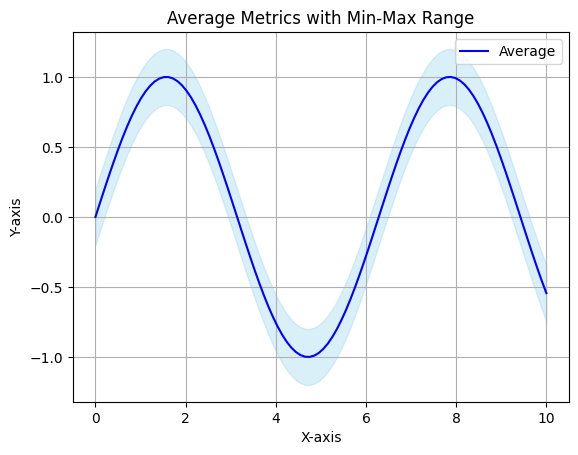

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
x = np.linspace(0, 10, 100)
y_avg = np.sin(x)
y_min = y_avg - 0.2
y_max = y_avg + 0.2

# Plot the average line
plt.plot(x, y_avg, color='blue', label='Average')

# Fill the region between min and max values
plt.fill_between(x, y_min, y_max, color='skyblue', alpha=0.3)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Average Metrics with Min-Max Range')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
